# Mise en place

In [7]:
from tensorflow import keras
import tensorflow as tf
import os
import pickle
from src.data import data
import os

BATCH_SIZE = 4096

# Directory containing the dataset pickles
DATA_DIR = os.path.join("data", "pickle_img_datasets")
# Directory to store model checkpoints
CHECKPOINT_DIR = os.path.join(
    "data", "models", "mlp_model_v2")
CHECKPOINT_PATH = os.path.join(
    CHECKPOINT_DIR, "cp_{val_loss:.2f}-{val_accuracy:.2f}.ckpt")
# Path to the history CSV file to store training metrics
HIST_CSV_PATH = os.path.join(CHECKPOINT_DIR, "history.csv")

# Load data
X_train = pickle.load(
    open(os.path.join(DATA_DIR, "X_train.pkl"), "rb")).fillna("")
y_train = pickle.load(open(os.path.join(DATA_DIR, "y_train.pkl"), "rb"))

X_test = pickle.load(
    open(os.path.join(DATA_DIR, "X_test.pkl"), "rb")).fillna("")
y_test = pickle.load(open(os.path.join(DATA_DIR, "y_test.pkl"), "rb"))

# Extract the features to be ready for preprocessing
X_train_features = X_train['designation'] + " " + X_train['description']
X_test_features = X_test['designation'] + " " + X_test['description']

# Define DataFrame names for preprocessing
X_train_features.name = "X_train"
X_test_features.name = "X_test"

# Load text model
text_model = keras.models.load_model(
    os.path.join("data", "models", "mlp_model_v2.h5"))

## Préprocessing et création des datasets

In [8]:
from src.data.data import PRDTYPECODE_DIC, convert_sparse_matrix_to_sparse_tensor, to_simplified_prdtypecode
from src.data.text_preproc_pipeline import TextPreprocess
from src.data.vectorization_pipeline import TfidfStemming


# Data preprocessing
text_preprocessor = TextPreprocess(TfidfStemming())
X_train_preproc = text_preprocessor.fit_transform(X_train_features)
X_train_preproc_tensor = convert_sparse_matrix_to_sparse_tensor(
    X_train_preproc)  # TODO Delete if not usefull anymore
X_test_preproc = text_preprocessor.transform(X_test_features)
X_test_preproc_tensor = convert_sparse_matrix_to_sparse_tensor(
    X_test_preproc)  # TODO Delete if not usefull anymore

# Convert the prdtypecode to their equivalent in a range from 0 to 26
y_train_simplified = to_simplified_prdtypecode(y_train)
# Transforms y_test to a one hot version
y_train_categorical = tf.keras.utils.to_categorical(
    y_train_simplified, num_classes=len(PRDTYPECODE_DIC.keys()))


# Convert the prdtypecode to their equivalent in a range from 0 to 26
y_test_simplified = to_simplified_prdtypecode(y_test)
# Transforms y_test to a one hot version
y_test_categorical = tf.keras.utils.to_categorical(
    y_test_simplified, num_classes=len(PRDTYPECODE_DIC.keys()))

# Create the Dataset to feed the model with correctly sized images by batch
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_preproc_tensor, y_train_categorical)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_test_preproc_tensor, y_test_categorical)).batch(BATCH_SIZE)

INFO:textpipeline:class:TfidfStemming
INFO:textpipeline:TextPreprocess.fit X_train 39.89 seconds
INFO:textpipeline:TextPreprocess.transform X_test 9.88 seconds


# Entrainement

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.train import latest_checkpoint

# Callbacks called between each epoch
cp_callbacks = [
    # Stop the training when there is no improvement in val_accuracy for x epochs
    EarlyStopping(monitor='val_accuracy', patience=3),
    # Save a checkpoint
    ModelCheckpoint(CHECKPOINT_PATH,
                    save_best_only=True,
                    mode="max",
                    monitor="val_accuracy",
                    save_weights_only=False,
                    verbose=1),
    # Insert the metrics into a CSV file
    CSVLogger(HIST_CSV_PATH, separator=',', append=True)
]

latest = latest_checkpoint(CHECKPOINT_DIR)
if (latest is not None):
    print("Loading checkpoint", latest)
    text_model.load_weights(latest)
else:
    print("No checkpoint to load")


loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=1e-3)
text_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

text_model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    callbacks=cp_callbacks)

No checkpoint to load
Epoch 1/100


2023-04-24 22:06:51.888408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [67932,27]
	 [[{{node Placeholder/_1}}]]
2023-04-24 22:06:52.311456: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1dafcb7160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-24 22:06:52.311485: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-04-24 22:06:52.313790: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-24 22:06:52.751508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
20

17/17 [==============================] - ETA: 0s - loss: 10.5045 - accuracy: 0.0382
Epoch 1: val_accuracy improved from -inf to 0.03468, saving model to data/models/mlp_model_v2/cp_8.45-0.03.ckpt


2023-04-24 22:06:54.657673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16984,27]
	 [[{{node Placeholder/_1}}]]
2023-04-24 22:06:54.834656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_8.45-0.03.ckpt/assets


2023-04-24 22:06:54.896625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_8.45-0.03.ckpt/assets


17/17 [==============================] - 3s 127ms/step - loss: 10.5045 - accuracy: 0.0382 - val_loss: 8.4544 - val_accuracy: 0.0347
Epoch 2/100
14/17 [=======================>......] - ETA: 0s - loss: 7.8843 - accuracy: 0.0465
Epoch 2: val_accuracy improved from 0.03468 to 0.04822, saving model to data/models/mlp_model_v2/cp_5.96-0.05.ckpt


2023-04-24 22:06:55.452964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:06:55.499734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_5.96-0.05.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_5.96-0.05.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 7.6929 - accuracy: 0.0472 - val_loss: 5.9560 - val_accuracy: 0.0482
Epoch 3/100
16/17 [===========================>..] - ETA: 0s - loss: 5.3084 - accuracy: 0.0830
Epoch 3: val_accuracy improved from 0.04822 to 0.14025, saving model to data/models/mlp_model_v2/cp_4.13-0.14.ckpt


2023-04-24 22:06:56.029996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:06:56.075884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_4.13-0.14.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_4.13-0.14.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 5.2778 - accuracy: 0.0846 - val_loss: 4.1312 - val_accuracy: 0.1402
Epoch 4/100
16/17 [===========================>..] - ETA: 0s - loss: 3.7638 - accuracy: 0.2021
Epoch 4: val_accuracy improved from 0.14025 to 0.25041, saving model to data/models/mlp_model_v2/cp_3.14-0.25.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_3.14-0.25.ckpt/assets


2023-04-24 22:06:56.617074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:06:56.663592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_3.14-0.25.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 3.7472 - accuracy: 0.2040 - val_loss: 3.1421 - val_accuracy: 0.2504
Epoch 5/100
16/17 [===========================>..] - ETA: 0s - loss: 2.8527 - accuracy: 0.2940
Epoch 5: val_accuracy improved from 0.25041 to 0.32195, saving model to data/models/mlp_model_v2/cp_2.49-0.32.ckpt


2023-04-24 22:06:57.192071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:06:57.238546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_2.49-0.32.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_2.49-0.32.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 2.8412 - accuracy: 0.2953 - val_loss: 2.4923 - val_accuracy: 0.3220
Epoch 6/100
16/17 [===========================>..] - ETA: 0s - loss: 2.2292 - accuracy: 0.3705
Epoch 6: val_accuracy improved from 0.32195 to 0.40132, saving model to data/models/mlp_model_v2/cp_2.04-0.40.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_2.04-0.40.ckpt/assets


2023-04-24 22:06:57.772028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:06:57.817667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_2.04-0.40.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 2.2207 - accuracy: 0.3720 - val_loss: 2.0430 - val_accuracy: 0.4013
Epoch 7/100
17/17 [==============================] - ETA: 0s - loss: 1.7837 - accuracy: 0.4516
Epoch 7: val_accuracy improved from 0.40132 to 0.47297, saving model to data/models/mlp_model_v2/cp_1.73-0.47.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.73-0.47.ckpt/assets


2023-04-24 22:06:58.343176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:06:58.387770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.73-0.47.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 1.7837 - accuracy: 0.4516 - val_loss: 1.7278 - val_accuracy: 0.4730
Epoch 8/100
17/17 [==============================] - ETA: 0s - loss: 1.4688 - accuracy: 0.5342
Epoch 8: val_accuracy improved from 0.47297 to 0.54033, saving model to data/models/mlp_model_v2/cp_1.50-0.54.ckpt


2023-04-24 22:06:58.910674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:06:58.955380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.50-0.54.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.50-0.54.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 1.4688 - accuracy: 0.5342 - val_loss: 1.5011 - val_accuracy: 0.5403
Epoch 9/100
16/17 [===========================>..] - ETA: 0s - loss: 1.2436 - accuracy: 0.6056
Epoch 9: val_accuracy improved from 0.54033 to 0.59232, saving model to data/models/mlp_model_v2/cp_1.33-0.59.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.33-0.59.ckpt/assets


2023-04-24 22:06:59.486395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:06:59.530788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.33-0.59.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 1.2394 - accuracy: 0.6066 - val_loss: 1.3343 - val_accuracy: 0.5923
Epoch 10/100
15/17 [=========================>....] - ETA: 0s - loss: 1.0739 - accuracy: 0.6598
Epoch 10: val_accuracy improved from 0.59232 to 0.62942, saving model to data/models/mlp_model_v2/cp_1.21-0.63.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.21-0.63.ckpt/assets


2023-04-24 22:07:00.051791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:00.095753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.21-0.63.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 1.0661 - accuracy: 0.6617 - val_loss: 1.2085 - val_accuracy: 0.6294
Epoch 11/100
17/17 [==============================] - ETA: 0s - loss: 0.9280 - accuracy: 0.7092
Epoch 11: val_accuracy improved from 0.62942 to 0.66357, saving model to data/models/mlp_model_v2/cp_1.11-0.66.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.11-0.66.ckpt/assets


2023-04-24 22:07:00.625036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:00.668626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.11-0.66.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.9280 - accuracy: 0.7092 - val_loss: 1.1115 - val_accuracy: 0.6636
Epoch 12/100
17/17 [==============================] - ETA: 0s - loss: 0.8199 - accuracy: 0.7491
Epoch 12: val_accuracy improved from 0.66357 to 0.69354, saving model to data/models/mlp_model_v2/cp_1.04-0.69.ckpt


2023-04-24 22:07:01.182146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:01.225107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.04-0.69.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_1.04-0.69.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.8199 - accuracy: 0.7491 - val_loss: 1.0357 - val_accuracy: 0.6935
Epoch 13/100
17/17 [==============================] - ETA: 0s - loss: 0.7318 - accuracy: 0.7806
Epoch 13: val_accuracy improved from 0.69354 to 0.71420, saving model to data/models/mlp_model_v2/cp_0.98-0.71.ckpt


2023-04-24 22:07:01.747065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:01.791396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.98-0.71.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.98-0.71.ckpt/assets


17/17 [==============================] - 1s 46ms/step - loss: 0.7318 - accuracy: 0.7806 - val_loss: 0.9756 - val_accuracy: 0.7142
Epoch 14/100
16/17 [===========================>..] - ETA: 0s - loss: 0.6627 - accuracy: 0.8054
Epoch 14: val_accuracy improved from 0.71420 to 0.72951, saving model to data/models/mlp_model_v2/cp_0.93-0.73.ckpt


2023-04-24 22:07:02.512126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:02.557123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.93-0.73.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.93-0.73.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.6593 - accuracy: 0.8063 - val_loss: 0.9272 - val_accuracy: 0.7295
Epoch 15/100
17/17 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.8291
Epoch 15: val_accuracy improved from 0.72951 to 0.74376, saving model to data/models/mlp_model_v2/cp_0.89-0.74.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.89-0.74.ckpt/assets


2023-04-24 22:07:03.091860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:03.136347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.89-0.74.ckpt/assets


17/17 [==============================] - 1s 33ms/step - loss: 0.5983 - accuracy: 0.8291 - val_loss: 0.8878 - val_accuracy: 0.7438
Epoch 16/100
16/17 [===========================>..] - ETA: 0s - loss: 0.5509 - accuracy: 0.8466
Epoch 16: val_accuracy improved from 0.74376 to 0.75453, saving model to data/models/mlp_model_v2/cp_0.86-0.75.ckpt


2023-04-24 22:07:03.659091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:03.705605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.86-0.75.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.86-0.75.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.5476 - accuracy: 0.8479 - val_loss: 0.8553 - val_accuracy: 0.7545
Epoch 17/100
16/17 [===========================>..] - ETA: 0s - loss: 0.5044 - accuracy: 0.8625
Epoch 17: val_accuracy improved from 0.75453 to 0.76295, saving model to data/models/mlp_model_v2/cp_0.83-0.76.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.83-0.76.ckpt/assets


2023-04-24 22:07:04.235932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:04.280562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.83-0.76.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.5013 - accuracy: 0.8636 - val_loss: 0.8283 - val_accuracy: 0.7630
Epoch 18/100
17/17 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8775
Epoch 18: val_accuracy improved from 0.76295 to 0.76972, saving model to data/models/mlp_model_v2/cp_0.81-0.77.ckpt


2023-04-24 22:07:04.807604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:04.853571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.81-0.77.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.81-0.77.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.4637 - accuracy: 0.8775 - val_loss: 0.8057 - val_accuracy: 0.7697
Epoch 19/100
17/17 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8880
Epoch 19: val_accuracy improved from 0.76972 to 0.77396, saving model to data/models/mlp_model_v2/cp_0.79-0.77.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.79-0.77.ckpt/assets


2023-04-24 22:07:05.384553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:05.429428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.79-0.77.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.4298 - accuracy: 0.8880 - val_loss: 0.7867 - val_accuracy: 0.7740
Epoch 20/100
17/17 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8985
Epoch 20: val_accuracy improved from 0.77396 to 0.77844, saving model to data/models/mlp_model_v2/cp_0.77-0.78.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.77-0.78.ckpt/assets


2023-04-24 22:07:05.946574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:05.991712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.77-0.78.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.4010 - accuracy: 0.8985 - val_loss: 0.7706 - val_accuracy: 0.7784
Epoch 21/100
16/17 [===========================>..] - ETA: 0s - loss: 0.3774 - accuracy: 0.9052
Epoch 21: val_accuracy improved from 0.77844 to 0.78227, saving model to data/models/mlp_model_v2/cp_0.76-0.78.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.76-0.78.ckpt/assets


2023-04-24 22:07:06.516135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:06.560094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.76-0.78.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.3744 - accuracy: 0.9061 - val_loss: 0.7568 - val_accuracy: 0.7823
Epoch 22/100
17/17 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.9135
Epoch 22: val_accuracy improved from 0.78227 to 0.78615, saving model to data/models/mlp_model_v2/cp_0.74-0.79.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.74-0.79.ckpt/assets


2023-04-24 22:07:07.089740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:07.132744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.74-0.79.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.3520 - accuracy: 0.9135 - val_loss: 0.7450 - val_accuracy: 0.7862
Epoch 23/100
16/17 [===========================>..] - ETA: 0s - loss: 0.3331 - accuracy: 0.9175
Epoch 23: val_accuracy improved from 0.78615 to 0.78921, saving model to data/models/mlp_model_v2/cp_0.73-0.79.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.73-0.79.ckpt/assets


2023-04-24 22:07:07.656814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:07.699569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.73-0.79.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.3304 - accuracy: 0.9185 - val_loss: 0.7348 - val_accuracy: 0.7892
Epoch 24/100
16/17 [===========================>..] - ETA: 0s - loss: 0.3135 - accuracy: 0.9246
Epoch 24: val_accuracy improved from 0.78921 to 0.79257, saving model to data/models/mlp_model_v2/cp_0.73-0.79.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.73-0.79.ckpt/assets


2023-04-24 22:07:08.220528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:08.263852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.73-0.79.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.3108 - accuracy: 0.9254 - val_loss: 0.7261 - val_accuracy: 0.7926
Epoch 25/100
16/17 [===========================>..] - ETA: 0s - loss: 0.2968 - accuracy: 0.9292
Epoch 25: val_accuracy improved from 0.79257 to 0.79328, saving model to data/models/mlp_model_v2/cp_0.72-0.79.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.72-0.79.ckpt/assets


2023-04-24 22:07:08.797113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:08.840390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.72-0.79.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.2941 - accuracy: 0.9303 - val_loss: 0.7185 - val_accuracy: 0.7933
Epoch 26/100
17/17 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.9342
Epoch 26: val_accuracy improved from 0.79328 to 0.79534, saving model to data/models/mlp_model_v2/cp_0.71-0.80.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.71-0.80.ckpt/assets


2023-04-24 22:07:09.358550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:09.401842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.71-0.80.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.2791 - accuracy: 0.9342 - val_loss: 0.7121 - val_accuracy: 0.7953
Epoch 27/100
17/17 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9382
Epoch 27: val_accuracy improved from 0.79534 to 0.79634, saving model to data/models/mlp_model_v2/cp_0.71-0.80.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.71-0.80.ckpt/assets


2023-04-24 22:07:09.930402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:09.973840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.71-0.80.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.2646 - accuracy: 0.9382 - val_loss: 0.7065 - val_accuracy: 0.7963
Epoch 28/100
16/17 [===========================>..] - ETA: 0s - loss: 0.2529 - accuracy: 0.9410
Epoch 28: val_accuracy improved from 0.79634 to 0.79799, saving model to data/models/mlp_model_v2/cp_0.70-0.80.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.70-0.80.ckpt/assets


2023-04-24 22:07:10.701537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:10.744937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.70-0.80.ckpt/assets


17/17 [==============================] - 1s 47ms/step - loss: 0.2503 - accuracy: 0.9419 - val_loss: 0.7016 - val_accuracy: 0.7980
Epoch 29/100
17/17 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9443
Epoch 29: val_accuracy improved from 0.79799 to 0.79975, saving model to data/models/mlp_model_v2/cp_0.70-0.80.ckpt


2023-04-24 22:07:11.275531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:11.331009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.70-0.80.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.70-0.80.ckpt/assets


17/17 [==============================] - 1s 36ms/step - loss: 0.2399 - accuracy: 0.9443 - val_loss: 0.6974 - val_accuracy: 0.7998
Epoch 30/100
16/17 [===========================>..] - ETA: 0s - loss: 0.2306 - accuracy: 0.9476
Epoch 30: val_accuracy improved from 0.79975 to 0.80111, saving model to data/models/mlp_model_v2/cp_0.69-0.80.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.69-0.80.ckpt/assets


2023-04-24 22:07:11.876081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:11.920026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.69-0.80.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.2283 - accuracy: 0.9484 - val_loss: 0.6938 - val_accuracy: 0.8011
Epoch 31/100
17/17 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9508
Epoch 31: val_accuracy improved from 0.80111 to 0.80258, saving model to data/models/mlp_model_v2/cp_0.69-0.80.ckpt


2023-04-24 22:07:12.448428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:12.494754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.69-0.80.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.69-0.80.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.2176 - accuracy: 0.9508 - val_loss: 0.6907 - val_accuracy: 0.8026
Epoch 32/100
17/17 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9529
Epoch 32: val_accuracy improved from 0.80258 to 0.80334, saving model to data/models/mlp_model_v2/cp_0.69-0.80.ckpt


2023-04-24 22:07:13.031821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:13.077980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.69-0.80.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.69-0.80.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.2095 - accuracy: 0.9529 - val_loss: 0.6881 - val_accuracy: 0.8033
Epoch 33/100
16/17 [===========================>..] - ETA: 0s - loss: 0.2020 - accuracy: 0.9535
Epoch 33: val_accuracy improved from 0.80334 to 0.80411, saving model to data/models/mlp_model_v2/cp_0.69-0.80.ckpt


2023-04-24 22:07:13.619879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:13.663712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.69-0.80.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.69-0.80.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.1998 - accuracy: 0.9542 - val_loss: 0.6858 - val_accuracy: 0.8041
Epoch 34/100
17/17 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9572
Epoch 34: val_accuracy improved from 0.80411 to 0.80458, saving model to data/models/mlp_model_v2/cp_0.68-0.80.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.80.ckpt/assets


2023-04-24 22:07:14.200421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:14.245990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.80.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.1914 - accuracy: 0.9572 - val_loss: 0.6839 - val_accuracy: 0.8046
Epoch 35/100
14/17 [=======================>......] - ETA: 0s - loss: 0.1871 - accuracy: 0.9581
Epoch 35: val_accuracy improved from 0.80458 to 0.80535, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


2023-04-24 22:07:14.775061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:14.817580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.1848 - accuracy: 0.9587 - val_loss: 0.6825 - val_accuracy: 0.8053
Epoch 36/100
14/17 [=======================>......] - ETA: 0s - loss: 0.1791 - accuracy: 0.9597
Epoch 36: val_accuracy improved from 0.80535 to 0.80588, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt


2023-04-24 22:07:15.353906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:15.398755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.1766 - accuracy: 0.9607 - val_loss: 0.6812 - val_accuracy: 0.8059
Epoch 37/100
16/17 [===========================>..] - ETA: 0s - loss: 0.1718 - accuracy: 0.9626
Epoch 37: val_accuracy did not improve from 0.80588
17/17 [==============================] - 0s 19ms/step - loss: 0.1698 - accuracy: 0.9633 - val_loss: 0.6801 - val_accuracy: 0.8055
Epoch 38/100
17/17 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9643
Epoch 38: val_accuracy improved from 0.80588 to 0.80599, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


2023-04-24 22:07:16.260386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:16.304399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.1634 - accuracy: 0.9643 - val_loss: 0.6794 - val_accuracy: 0.8060
Epoch 39/100
16/17 [===========================>..] - ETA: 0s - loss: 0.1598 - accuracy: 0.9648
Epoch 39: val_accuracy improved from 0.80599 to 0.80682, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


2023-04-24 22:07:16.832264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:16.876340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.1581 - accuracy: 0.9654 - val_loss: 0.6789 - val_accuracy: 0.8068
Epoch 40/100
16/17 [===========================>..] - ETA: 0s - loss: 0.1538 - accuracy: 0.9667
Epoch 40: val_accuracy improved from 0.80682 to 0.80705, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


2023-04-24 22:07:17.399501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:17.443933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 34ms/step - loss: 0.1522 - accuracy: 0.9672 - val_loss: 0.6785 - val_accuracy: 0.8071
Epoch 41/100
17/17 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9688
Epoch 41: val_accuracy did not improve from 0.80705
17/17 [==============================] - 0s 19ms/step - loss: 0.1463 - accuracy: 0.9688 - val_loss: 0.6784 - val_accuracy: 0.8066
Epoch 42/100
17/17 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9696
Epoch 42: val_accuracy improved from 0.80705 to 0.80711, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt


2023-04-24 22:07:18.286762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:18.329230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.1416 - accuracy: 0.9696 - val_loss: 0.6785 - val_accuracy: 0.8071
Epoch 43/100
17/17 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9712
Epoch 43: val_accuracy improved from 0.80711 to 0.80735, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


2023-04-24 22:07:18.862977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:18.906835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 33ms/step - loss: 0.1366 - accuracy: 0.9712 - val_loss: 0.6785 - val_accuracy: 0.8073
Epoch 44/100
15/17 [=========================>....] - ETA: 0s - loss: 0.1334 - accuracy: 0.9714
Epoch 44: val_accuracy improved from 0.80735 to 0.80776, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt


2023-04-24 22:07:19.633268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:19.678894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 47ms/step - loss: 0.1316 - accuracy: 0.9721 - val_loss: 0.6789 - val_accuracy: 0.8078
Epoch 45/100
16/17 [===========================>..] - ETA: 0s - loss: 0.1287 - accuracy: 0.9731
Epoch 45: val_accuracy improved from 0.80776 to 0.80841, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt


2023-04-24 22:07:20.690878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:20.734907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.1272 - accuracy: 0.9735 - val_loss: 0.6793 - val_accuracy: 0.8084
Epoch 46/100
17/17 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9740
Epoch 46: val_accuracy improved from 0.80841 to 0.80894, saving model to data/models/mlp_model_v2/cp_0.68-0.81.ckpt


2023-04-24 22:07:21.280241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-24 22:07:21.326088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


INFO:tensorflow:Assets written to: data/models/mlp_model_v2/cp_0.68-0.81.ckpt/assets


17/17 [==============================] - 1s 35ms/step - loss: 0.1238 - accuracy: 0.9740 - val_loss: 0.6798 - val_accuracy: 0.8089
Epoch 47/100
16/17 [===========================>..] - ETA: 0s - loss: 0.1216 - accuracy: 0.9742
Epoch 47: val_accuracy did not improve from 0.80894
17/17 [==============================] - 0s 19ms/step - loss: 0.1202 - accuracy: 0.9747 - val_loss: 0.6805 - val_accuracy: 0.8084
Epoch 48/100
14/17 [=======================>......] - ETA: 0s - loss: 0.1185 - accuracy: 0.9751
Epoch 48: val_accuracy did not improve from 0.80894
17/17 [==============================] - 0s 19ms/step - loss: 0.1167 - accuracy: 0.9754 - val_loss: 0.6811 - val_accuracy: 0.8085
Epoch 49/100
16/17 [===========================>..] - ETA: 0s - loss: 0.1135 - accuracy: 0.9764
Epoch 49: val_accuracy did not improve from 0.80894
17/17 [==============================] - 0s 19ms/step - loss: 0.1122 - accuracy: 0.9770 - val_loss: 0.6821 - val_accuracy: 0.8086


## Affichage des données d'entrainement

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/joff/miniconda3/envs/tf/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/joff/miniconda3/envs/tf/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/joff/miniconda3/envs/tf/lib/python

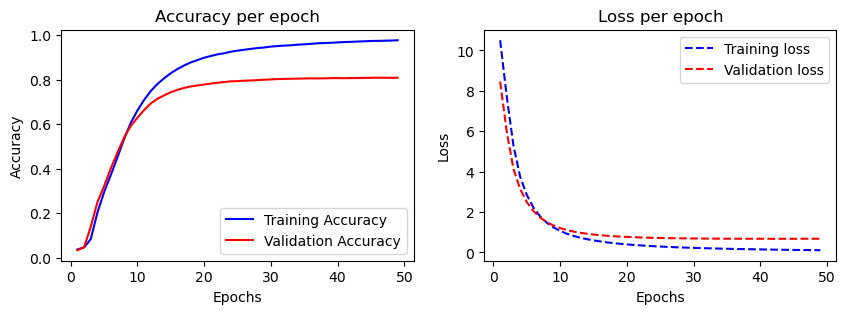

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

training_history = pd.read_csv(HIST_CSV_PATH, delimiter=",", header=0)

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(121)

# Labels des axes
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
ax1.plot(np.arange(1, training_history["accuracy"].count() + 1, 1),
         training_history["accuracy"],
         label='Training Accuracy',
         color='blue')

# Courbe de la précision sur l'échantillon de test
ax1.plot(np.arange(1, training_history["val_accuracy"].count() + 1, 1),
         training_history['val_accuracy'],
         label='Validation Accuracy',
         color='red')

ax1.legend()
ax1.set_title("Accuracy per epoch")

ax2 = fig.add_subplot(122)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax2.plot(np.arange(1, training_history["loss"].count() + 1, 1),
         training_history['loss'],
         label='Training loss',
         linestyle="dashed",
         color='blue')

ax2.plot(np.arange(1, training_history["val_loss"].count() + 1, 1),
         training_history['val_loss'],
         label='Validation loss',
         linestyle="dashed",
         color='red')

ax2.legend()
ax2.set_title("Loss per epoch")

# Affichage de la figure
plt.show()

# Analyse des performances

## Prédiction

In [11]:
import numpy as np
from src.data.data import to_normal_prdtypecode

y_pred_raw = text_model.predict(test_dataset)
y_pred = to_normal_prdtypecode([np.argmax(i) for i in y_pred_raw])

5/5 [==============================] - 0s 6ms/step


## Rapport de classification

In [12]:
from sklearn import metrics

print("Score accuracy :", metrics.accuracy_score(
    y_test, y_pred), "\n\n")
print(metrics.classification_report(y_test, y_pred))

Score accuracy : 0.8086434291097504 


              precision    recall  f1-score   support

          10       0.53      0.44      0.48       570
          40       0.64      0.69      0.66       508
          50       0.80      0.80      0.80       335
          60       0.92      0.85      0.88       179
        1140       0.73      0.79      0.76       536
        1160       0.93      0.93      0.93       786
        1180       0.77      0.56      0.65       165
        1280       0.68      0.66      0.67       958
        1281       0.63      0.52      0.57       411
        1300       0.90      0.93      0.92      1044
        1301       0.94      0.93      0.94       157
        1302       0.82      0.79      0.81       499
        1320       0.86      0.80      0.83       694
        1560       0.81      0.83      0.82      1030
        1920       0.91      0.93      0.92       889
        1940       0.93      0.86      0.89       167
        2060       0.80      0.79      0.7

## Matrice de confusion

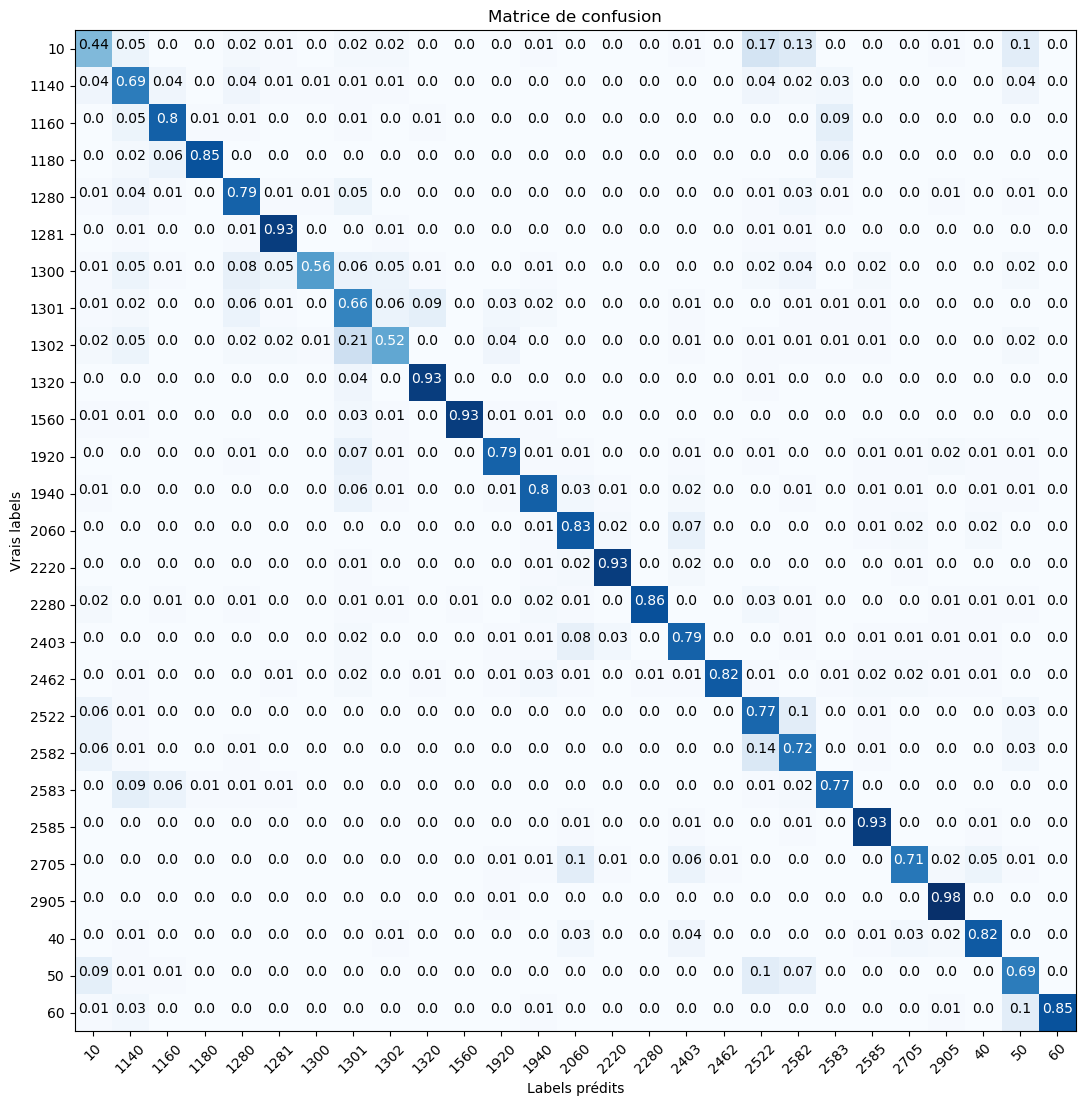

In [13]:
import itertools
from matplotlib import pyplot as plt


cnf_matrix = np.round(metrics.confusion_matrix(
    y_test, y_pred, normalize="true"), 2)

classes = range(0, len(PRDTYPECODE_DIC.keys()))

plt.figure(figsize=(13, 13))

plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
tick_marks = classes
plt.xticks(tick_marks, list(PRDTYPECODE_DIC.keys()))
plt.yticks(tick_marks, list(PRDTYPECODE_DIC.keys()))

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.xticks(rotation=45)
plt.show()

# Enregistrement du modèle

In [14]:
# Load the latest checkpoint to avoid overfitting
latest = latest_checkpoint(CHECKPOINT_DIR)
if (latest is not None):
    print("Loading checkpoint", latest)
    text_model.load_weights(latest)

# Save the model into a .h5 file
model_path = os.path.join(CHECKPOINT_DIR, "mlp_model_v2.h5")
text_model.save(model_path)
print("Modèle enregistré à l'adresse :", model_path)

DEBUG:h5py._conv:Creating converter from 5 to 3


Modèle enregistré à l'adresse : data/models/mlp_model_v2/mlp_model_v2.h5


# Vérification du bon enregistrement

In [15]:
from tensorflow import keras
import numpy as np
from sklearn import metrics
from src.data.data import to_normal_prdtypecode

# Load the model, predict and display classification report to be sure we have the same results
reconstructed_model = keras.models.load_model(model_path)

y_pred_raw = reconstructed_model.predict(test_dataset)
y_pred = to_normal_prdtypecode([np.argmax(i) for i in y_pred_raw])

print("Score accuracy :", metrics.accuracy_score(
    y_test, y_pred), "\n\n")
print(metrics.classification_report(y_test, y_pred))

5/5 [==============================] - 0s 5ms/step
Score accuracy : 0.8086434291097504 


              precision    recall  f1-score   support

          10       0.53      0.44      0.48       570
          40       0.64      0.69      0.66       508
          50       0.80      0.80      0.80       335
          60       0.92      0.85      0.88       179
        1140       0.73      0.79      0.76       536
        1160       0.93      0.93      0.93       786
        1180       0.77      0.56      0.65       165
        1280       0.68      0.66      0.67       958
        1281       0.63      0.52      0.57       411
        1300       0.90      0.93      0.92      1044
        1301       0.94      0.93      0.94       157
        1302       0.82      0.79      0.81       499
        1320       0.86      0.80      0.83       694
        1560       0.81      0.83      0.82      1030
        1920       0.91      0.93      0.92       889
        1940       0.93      0.86      0.89  